# Аспектный анализ тональности текстов

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/wegolev/aspect_sentiment_SentiRuEval-2015.git
# !pip install -r aspect_sentiment_SentiRuEval-2015/requirements.txt
# import sys; sys.path.append('./aspect_sentiment_SentiRuEval-2015')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [3]:
# Установка "нормальной" подсветки для темного фона
from ipymarkup.palette import material, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

colors = BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

for c in colors:
    color_name = c.name[0].capitalize() + c.name[1:]
    c.background = material(color_name, '900')

## Оригинальная разметка

In [4]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./aspect_sentiment_SentiRuEval-2015
xml_sentiments = 'datasets/SentiRuEval_car_markup_train.xml'

In [5]:
from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, show_markup

тексты с разметкой аспектов и тональностей: 

In [6]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

In [7]:
amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [8]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]

####  тональность (sentiment)

In [9]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 199


Текст №: 193


####  Аспекты (aspects)

In [10]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 199


Текст №: 193


## BIO-тэги для обучения модели

In [11]:
from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

In [12]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

Полное покрытие разметкой текста №: 199


Полное покрытие разметкой текста №: 193


### Разбиение текста на предложения, а предложений - на слова.

In [13]:
from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

In [14]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [15]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста №: 199


[('Этот', 'Other'), ('автомобиль', 'B-Whole'), ('в', 'Other'), ('нашей', 'Other'), ('семье', 'Other'), ('уже', 'Other'), ('7', 'Other'), ('лет', 'Other'), ('.', 'Other')] 



[('Никаких', 'Other'), ('серьёзных', 'Other'), ('проблем', 'Other'), ('с', 'Other'), ('ним', 'Other'), ('не', 'Other'), ('было', 'Other'), ('.', 'Other')] 



[('Всё', 'Other'), ('-таки', 'Other'), ('сборка', 'B-Reliability'), ('Кореи', 'I-Reliability')] 



[('Прекрасный', 'Other'), (',', 'Other'), ('обтянутый', 'B-Appearance'), ('светлой', 'I-Appearance'), ('кожей', 'I-Appearance'), ('салон', 'B-Comfort'), ('удобен', 'B-Comfort'), ('и', 'Other'), ('просторен', 'B-Comfort')] 



[('Большой', 'B-Comfort'), ('багажник', 'I-Comfort')] 



[('В', 'Other'), ('салон', 'B-Comfort'), ('вмещается', 'Other'), ('даже', 'Other'), ('стиральная', 'Other'), ('машина', 'Other'), ('!', 'Other'), ('Расход', 'B-Driveability'), ('топлива', 'I-Driveability'), ('10', 'Other')] 



[('В', 'Other'), ('машине', 'B-Driveability'), ('низкий', 'B-Driveability'), ('просвет', 'I-Driveability'), (',', 'Other'), ('поэтому', 'Other'), ('зимой', 'Other'), ('ездить', 'B-Driveability'), ('тяжело', 'I-Driveability')] 



[('Мощные', 'Other'), ('динамики', 'B-Comfort')] 



[('Огорчает', 'Other'), ('наличие', 'Other'), ('кассетной', 'B-Comfort'), ('автомагнитолы', 'I-Comfort'), (',', 'Other'), ('а', 'Other'), ('не', 'Other'), ('MP3', 'Other'), ('.', 'Other')] 



[('Запчасти', 'B-Costs'), ('на', 'Other'), ('корейские', 'Other'), ('автомобили', 'Other'), ('дешевле', 'B-Costs'), (',', 'Other'), ('чем', 'Other'), ('на', 'Other'), ('другие', 'Other'), ('иномарки', 'B-Costs')] 



[('Конечно', 'Other'), (',', 'Other'), ('важно', 'Other'), ('ухаживать', 'Other'), ('за', 'Other'), ('машиной', 'B-Whole'), (',', 'Other'), ('а', 'Other'), ('не', 'Other'), ('просто', 'Other')] 



[('Впереди', 'Other'), ('много', 'B-Comfort'), ('места', 'I-Comfort'), ('-', 'Other'), ('ноги', 'Other'), ('вытянуты', 'Other'), ('.', 'Other')] 



[('Можно', 'Other'), ('даже', 'Other'), ('комфортно', 'B-Comfort'), ('ночевать', 'Other'), ('в', 'Other'), ('ней', 'Other'), ('.', 'Other')] 



[('Вообще', 'Other'), (',', 'Other'), ('машина', 'B-Whole'), ('для', 'Other'), ('семьи', 'Other'), ('и', 'Other'), ('путешествий', 'Other'), ('.', 'Other')] 



[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('Надёжное', 'B-Reliability')] 



[('По', 'Other'), ('цене', 'B-Costs'), ('Форд', 'B-Costs'), ('-', 'I-Costs'), ('Фиесты', 'I-Costs'), ('получаете', 'Other'), ('авто', 'B-Whole'), ('люкс', 'I-Whole'), ('-класса', 'I-Whole')] 

Разбиение на предложения и BIO токенизация текста №: 193


[('Купил', 'Other'), ('я', 'Other'), ('себе', 'Other'), ('новый', 'Other'), ('Opel', 'B-Whole'), ('Insigna', 'I-Whole'), ('1', 'I-Whole'), ('.8', 'I-Whole'), ('недавно', 'Other'), ('и', 'Other')] 



[('Начнем', 'Other'), ('с', 'Other'), ('плюсов', 'Other'), ('данной', 'Other'), ('машины', 'Other'), ('.', 'Other')] 



[('Очень', 'Other'), ('понравилась', 'Other'), ('жесткая', 'B-Driveability'), ('подвеска', 'I-Driveability')] 



[('Заводиться', 'B-Reliability'), ('сразу', 'Other'), ('в', 'Other'), ('-30', 'Other'), ('градусов', 'Other'), ('без', 'Other'), ('проблем', 'Other'), ('.', 'Other')] 



[('Салон', 'B-Comfort'), ('прогревается', 'Other'), ('моментально', 'Other'), ('.', 'Other')] 



[('Огромный', 'B-Comfort'), ('размер', 'I-Comfort'), ('багажника', 'I-Comfort'), ('в', 'Other'), ('отличии', 'Other'), ('от', 'Other'), ('других', 'Other'), ('Хэтчбэк', 'B-Comfort')] 



[('Очень', 'Other'), ('хороший', 'Other'), ('дизайн', 'B-Appearance'), ('салона', 'I-Appearance'), (',', 'Other'), ('нечего', 'Other'), ('не', 'Other'), ('где', 'Other'), ('не', 'B-Reliability'), ('отваливаться', 'I-Reliability')] 



[('Также', 'Other'), ('обрадовал', 'Other'), ('сенсорный', 'B-Comfort'), ('дисплей', 'I-Comfort')] 



[('Теперь', 'Other'), ('перейдем', 'Other'), ('к', 'Other'), ('минусам', 'Other'), ('.', 'Other')] 



[('В', 'Other'), ('сильные', 'Other'), ('морозы', 'Other'), ('двери', 'B-Reliability'), ('примерзают', 'I-Reliability'), ('и', 'Other'), ('плохо', 'Other'), ('открываются', 'B-Reliability')] 



[('Очень', 'Other'), ('прожорливый', 'B-Driveability'), ('двигатель', 'B-Driveability'), ('в', 'Other'), ('плане', 'Other'), ('масла', 'B-Driveability'), ('и', 'Other'), ('бензина', 'B-Driveability')] 



[('В', 'Other'), ('заде', 'Other'), ('хоть', 'Other'), ('и', 'Other'), ('стоит', 'Other'), ('3', 'Other'), ('сиденья', 'B-Comfort'), ('но', 'Other'), ('место', 'Other'), ('для', 'Other')] 



[('Датчик', 'B-Reliability'), ('показывает', 'Other'), ('неправильное', 'Other'), ('давление', 'B-Reliability'), ('в', 'I-Reliability'), ('шинах', 'I-Reliability')] 



[('Низкая', 'B-Safety'), ('посадка', 'I-Safety')] 



[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('Идеальнай', 'Other'), ('хэтчбэк', 'B-Whole')] 



##  Подготовка данных для обучения: 

In [16]:
from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

In [17]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./aspect_sentiment_eval
xml_train = 'datasets/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/SentiRuEval_car_markup_test.xml'

### Токенизация: 

In [18]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)


#### разбиение на предложения дало нам столько коротких текстов:

In [19]:
len(training_data), len(test_data)

(2210, 1922)

In [20]:
all_data = training_data + test_data

In [21]:
vocabulary,labels = form_vocabulary_and_tagset(all_data)

In [22]:
labels

{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### а размер словаря:

In [23]:
len(vocabulary), len(labels)

(11333, 15)

#### индексация:

In [24]:
from dlnlputils.sentiment_utils import Converter, generate_markup

In [25]:
converter = Converter(vocabulary,labels)

In [26]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



### Нейросети

In [27]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/


In [28]:
# !pip3 install wget

In [29]:
# import zipfile
import gensim
# import wget

# model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)
# model_file = 'datasets/' + model_url.split('/')[-1]

In [30]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

words = ['тачка', 'двигатель', 'ауди']

for word in words:
    #if word in w2v_model:
           
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')
    
    #else: print(word + ' is not present in the model')

жигулёнка 0.7488206028938293
ишачка 0.7310285568237305
грузовичка 0.7278669476509094
жигулёнок 0.7127147912979126
жигуленок 0.706432044506073
тележка 0.6995413303375244
мопед 0.6990943551063538
сачка 0.6923120021820068
катафалка 0.6904969215393066
бричка 0.6855131387710571


двигатели 0.9118232131004333
гипердвигатель 0.8655393719673157
электродвигатель 0.8446590900421143
мотор 0.8106048107147217
электромотор 0.8067885637283325
авиадвигатель 0.7910488843917847
движок 0.7793391346931458
перводвигатель 0.7768319845199585
двигательный 0.7394744157791138
турбина 0.7326768636703491


bmw 0.7961359620094299
бмв 0.7914926409721375
аудь 0.7911134958267212
тойота 0.7723557353019714
мерседес 0.7654416561126709
mw 0.7585864067077637
bmv 0.7522681951522827
форд 0.7281615734100342
тойот 0.7268385887145996
лексус 0.7258473634719849




In [31]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    #if word in w2v_model:
    vector = w2v_model.get_vector(word)
    index  = converter.words_to_index([word])
    numpy_embeddings[index] = vector
        
    #else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их
2. Двунаправленная

In [32]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

### Взвешеная функция потерь

In [33]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1
        
tag_counter.most_common()     

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [34]:
class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))


class_weights /= class_divs


print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


In [35]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

#### training

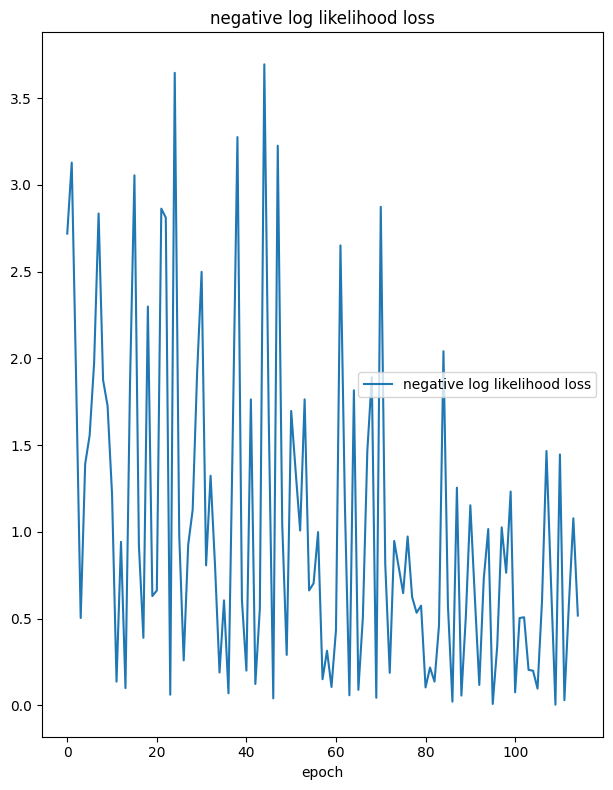

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.003, max:    3.695, cur:    0.517)


In [36]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        tag_scores     = model(encoded_recipe)
        
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 0:
            # liveplot.update({'negative log likelihood loss': loss}) # RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
            liveplot.update({'negative log likelihood loss': loss.detach()}) 
            liveplot.draw()
            

In [37]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [38]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:



истинные тэги:


предсказанные тэги:


### Статистика

##### 1.  Количество верно предсказанных тэгов:

In [39]:
from dlnlputils.sentiment_utils import tag_statistics

In [40]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для Other:
  корректно:	 16259
      всего:	 19922
% корректно:	 81.61329183816886

для B-Whole:
  корректно:	 514
      всего:	 673
% корректно:	 76.37444279346211

для B-Driveability:
  корректно:	 470
      всего:	 1066
% корректно:	 44.090056285178235

для I-Driveability:
  корректно:	 284
      всего:	 711
% корректно:	 39.943741209563996

для B-Appearance:
  корректно:	 154
      всего:	 275
% корректно:	 56.00000000000001

для I-Appearance:
  корректно:	 40
      всего:	 100
% корректно:	 40.0

для B-Reliability:
  корректно:	 315
      всего:	 809
% корректно:	 38.93695920889987

для I-Whole:
  корректно:	 100
      всего:	 213
% корректно:	 46.948356807511736

для B-Comfort:
  корректно:	 588
      всего:	 1067
% корректно:	 55.10777881911903

для I-Comfort:
  корректно:	 204
      всего:	 497
% корректно:	 41.04627766599598

для I-Reliability:
  корректно:	 160
      всего:	 475
% корректно:	 33.68421052631579

для B-Costs:
  корректно:	

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

In [41]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [42]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, converter, sentence)
    y_true += tags

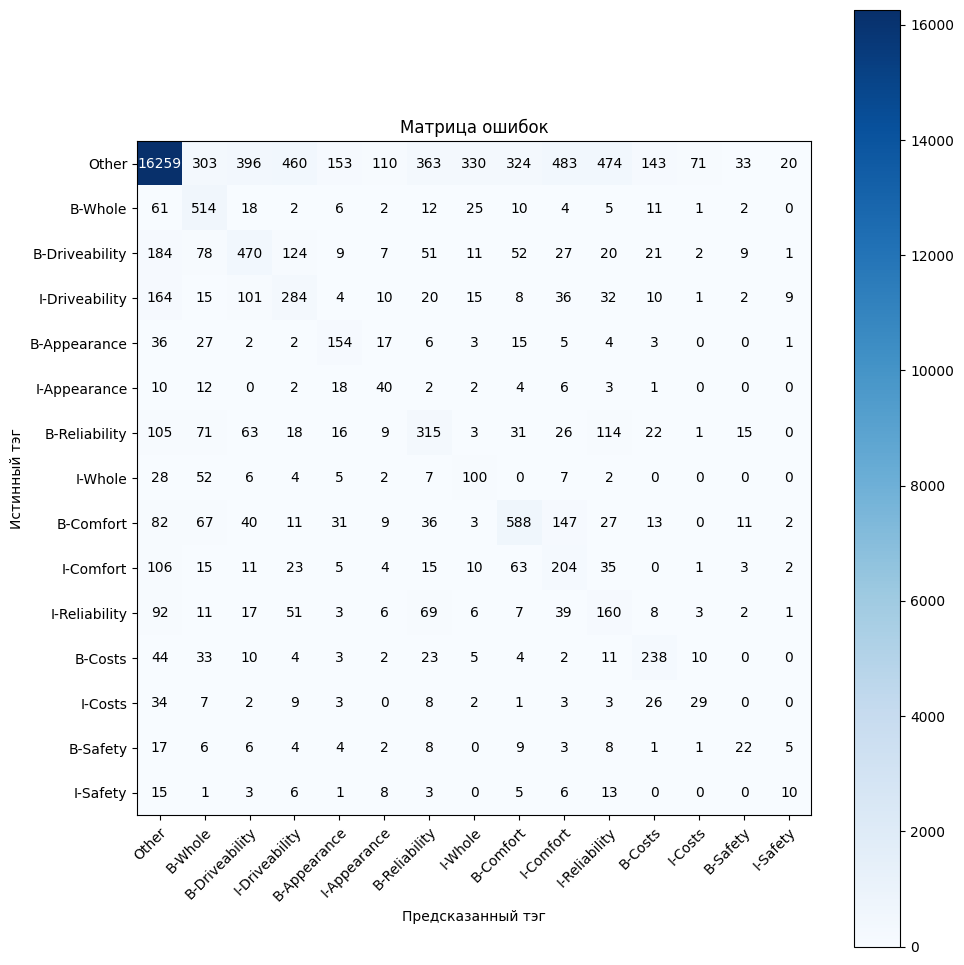

In [43]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), 
                      title='Матрица ошибок')

plt.show()

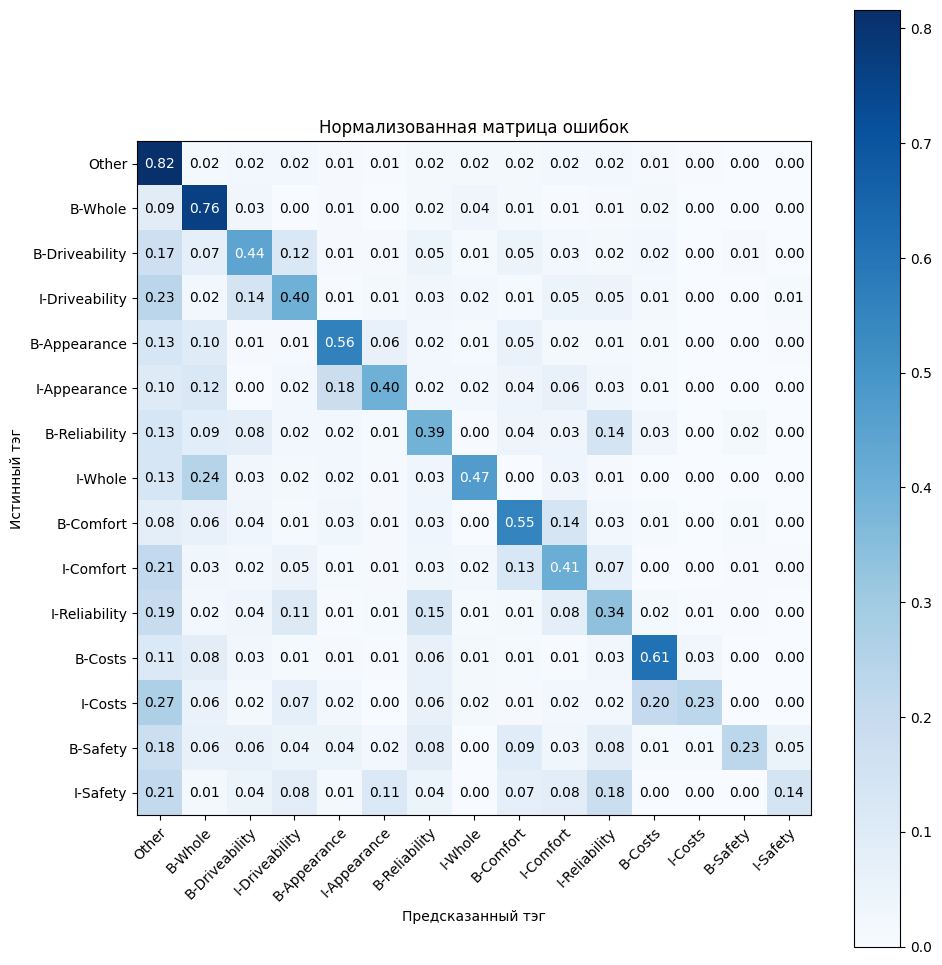

In [44]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()